In [1]:
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from scipy import signal
from scipy.signal import find_peaks_cwt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

In [31]:
class Analysis():
    def __init__(self,filePath,grid_lenth):
        self.filePath=filePath
        self.lenth=0
        self.datas=[]
        self.data_columns=[]
        self.hatching_points=[]
        self.onset_points=[]
        self.max_min_diff=[]
        self.grid_lenth=grid_lenth
        self.filtered_signals=[]
        self.total_movements=[]
        self.average_above_threshold=[]
        self.durations=[]
        self.moving_percentage=[]
        self.average_bout=[]

    def All_computing(self):
        self.loading_datas()
        self.max_min_run()
        self.hatching_onset_detection()
        self.hatching_complete_detection()
        self.total_movement_quantity()
        self.average_movement_magnitude()
        self.calculate_durations()
        self.calculate_moving_percentage()
        self.calculate_average_bout()


    def loading_datas(self):
        print("Data loading...")
        for each_file in os.listdir(self.filePath):
            if each_file.endswith(".csv"):
                current=pd.read_csv(self.filePath + each_file)
                self.datas.append(current)
                self.data_columns.append(current.columns)
                print("    "+each_file+" Loaded")
        self.lenth =len(self.datas)
        print(str(self.lenth)+" files has been loaded")

    def knn_norm(self,data, k=7, mode="max"):
        lenth = len(data)
        output_list = []
        for i in range(lenth - k):
            if mode == "max":
                output_list.append((np.max(data[i:i + k])))
            elif mode == "mean":
                output_list.append((np.mean(data[i:i + k])))
            elif mode == "min":
                output_list.append((np.min(data[i:i + k])))
        return np.hstack((np.ones(lenth-len(output_list))*output_list[0],np.array(output_list)))

    def max_min_run(self):
        for each_ in range(self.lenth):
            diffs=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                normBright = np.array(self.datas[each_][self.data_columns[each_][j]])
                normBright_max = self.knn_norm(normBright, 60, "max")
                normBright_min = self.knn_norm(normBright, 60, "min")
                diff = normBright_max - normBright_min
                diffs.append(copy.deepcopy(diff))
            self.max_min_diff.append(diffs)
        #self.max_min_diff=np.array(self.max_min_diff)


    def hatching_onset_detection(self):
        print("calculate hatching onset point")
        for each_ in range(self.lenth):
            onset_point=[]
            filtered_signals=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                t1=0
                diff=self.max_min_diff[each_][j]
                cut= diff[0:5000]
                threshold= np.max(cut)
                diff[np.where(diff<=threshold)[0]]=0
                #diff[np.where(diff>threshold)[0][0]]=0
                filtered_signals.append(diff)
                for i in range(int(len(diff)*0.8)):
                    p=len(diff[i:i+int(len(diff)*0.01)][diff[i:i+int(len(diff)*0.01)]>threshold])
                    if p > int(len(diff)*0.01*0.035):
                        t1=i
                        #print(j,p,i)
                        break
                if t1==0:
                    for i in range(int(len(diff)*0.8)):
                        if diff[i]!=0:
                            break
                    onset_point.append(i)
                else:
                    onset_point.append(np.where(diff>threshold)[0][0])
                #onset_point.append(np.where(diff>threshold)[0][0])
            self.onset_points.append(onset_point)
            self.filtered_signals.append(filtered_signals)
        #self.onset_points=np.array(self.onset_points)
        #self.filtered_signals=np.array(self.filtered_signals)

    def hatching_complete_detection(self):
        print("calculate hatching complete point")
        for each_ in range(self.lenth):
            hatching_=[]
            maxss=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                ndiff=self.knn_norm(self.filtered_signals[each_][j],200,"mean")
                increase_point=np.where(ndiff>np.mean(ndiff)*6)[0][0]
                #print(self.onset_points[each_][j])
                #print(increase_point)
                #print(np.where(ndiff==np.max(ndiff))[0][0])
                if (increase_point==[]) or (increase_point-self.onset_points[each_][j] < 15000):
                    increase_point=np.where(ndiff==np.max(ndiff))[0][0]
                cut=ndiff[:increase_point]
                maxs =find_peaks_cwt(cut[self.onset_points[each_][j]:],500)
                #print(len(maxs))
                maxs+=self.onset_points[each_][j]
                if len(maxs)>=2:
                    cut=cut[maxs[-2]:maxs[-1]]
                    hatching_.append(int((maxs[-1]+(maxs[-2]+maxs[-1])/2)/2))
                else:
                    hatching_.append(np.where(ndiff==np.max(ndiff))[0][0])
                '''else:
                    print(maxs)
                    print(cut,len(cut),type(cut))
                    cut1=copy.deepcopy(np.array(cut[-int(len(ndiff)*0.02):maxs[-1]]))
                    #print(cut1,len(cut1),type(cut1))
                    point=np.where(cut1==np.min(cut1))[0][-1]+maxs[-1]-int(len(ndiff)*0.05)
                    hatching_.append(maxs)'''
                
                #
                '''maxs =find_peaks_cwt(cut[self.onset_points[each_][j]:],500)
                maxs+=10000
                cuted=maxs[-2]
                maxss.append((maxs[-2],maxs[-1]))
                cut=cut[maxs[-2]:maxs[-1]]
                mins =find_peaks_cwt(cut**-1,80)
                predict=0
                reverse_min = mins[::-1]
                for i in range(len(mins)):
                    if i ==0:
                        continue
                    else:
                        if cut[reverse_min[i]] > cut[reverse_min[i-1]]:
                            predict=reverse_min[i-1]+maxs[-2]
                            #hatching_points.append(predict)
                            break
                if predict<(maxs[-2]+maxs[-1])/2:
                    hatching_.append(int((maxs[-1]+(maxs[-2]+maxs[-1])/2)/2))
                else:
                    hatching_.append(predict)'''
            self.hatching_points.append(hatching_)
                
    def hatching_complete_detection_old(self):
        print("calculate hatching complete")
        for each_ in range(self.lenth):
            hatching_=[]
            maxss=[]
            for j in tqdm.tqdm(range(self.grid_lenth)):
                ndiff=self.knn_norm(self.max_min_diff[each_][j],8000,"mean")
                increase_point=np.where(ndiff>np.mean(ndiff)*1.2)[0][0]
                cut=ndiff[:increase_point]
                maxs =find_peaks_cwt(cut[10000:],500)
                maxs+=10000
                cuted=maxs[-2]
                maxss.append((maxs[-2],maxs[-1]))
                cut=cut[maxs[-2]:maxs[-1]]
                mins =find_peaks_cwt(cut**-1,80)
                predict=0
                reverse_min = mins[::-1]
                for i in range(len(mins)):
                    if i ==0:
                        continue
                    else:
                        if cut[reverse_min[i]] > cut[reverse_min[i-1]]:
                            predict=reverse_min[i-1]+maxs[-2]
                            #hatching_points.append(predict)
                            break
                if predict<(maxs[-2]+maxs[-1])/2:
                    hatching_.append(int((maxs[-1]+(maxs[-2]+maxs[-1])/2)/2))
                else:
                    hatching_.append(predict)
            self.hatching_points.append(hatching_)
        #self.hatching_points=np.array(self.hatching_points)

    def total_movement_quantity(self):
        print("total movement quantity...")
        self.total_movements=[]
        for each_ in range(self.lenth):
            Sum_above_threshold=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Sum_above_threshold.append(len(np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0]))
            self.total_movements.append(Sum_above_threshold)
        #self.total_movements=np.array(self.total_movements)

    def average_movement_magnitude(self):
        print("average movement magnitude...")
        for each_ in range(self.lenth):
            Average_of_values=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Average_of_values.append(np.average(self.datas[each_][self.data_columns[each_][i]][np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0]]))
            self.average_above_threshold.append(Average_of_values)
        #self.average_above_threshold=np.array(self.average_above_threshold)

    def calculate_durations(self):
        print("calculate durations...")
        for each_ in range(self.lenth):
            Duration=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Duration.append(len(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]))
            self.durations.append(Duration)
        #self.durations=np.array(self.durations)

    def calculate_moving_percentage(self):
        print("calculate moving percentage...")
        for each_ in range(self.lenth):
            Moving_Percentage=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                Moving_Percentage.append(len(np.where(self.filtered_signals[each_][i][self.onset_points[each_][i]:self.hatching_points[each_][i]]!=0)[0])/len(self.filtered_signals[each_][i]))
            self.moving_percentage.append(Moving_Percentage)
        #self.moving_percentage=np.array(self.moving_percentage)

    def calculate_average_bout(self):
        print("calculate average bout")
        for each_ in range(self.lenth):
            Average_bout=[]
            for i in tqdm.tqdm(range(self.grid_lenth)):
                pos = np.where(self.filtered_signals[each_][i] > 0)[0]
                split = np.where(np.diff(pos) != 1)[0] + 1
                arr=np.split(self.filtered_signals[each_][i][pos],split)
                lenths=[]
                for j in arr:
                    lenths.append(len(j))
                Average_bout.append(np.mean(lenths))
            self.average_bout.append(Average_bout)
        #self.average_bout=np.array(self.average_bout)


    def Box_plot(self,data,n):
        plt.figure(figsize=(13,10), dpi= 80)
        sns.boxplot(y=data[n])
        plt.show()

    def specgram_plot(self,n):
        plt.figure(figsize=(8,23))
        for i in range(24):
            current=np.array_split(self.datas[n][self.data_columns[n][i]],8)
            for j in range(8):
                plt.subplot(24,8,i*8+j+1)
                plt.specgram(current[j], Fs=10)
                #plt.xticks([])
                #plt.yticks([])
                if j==0:
                    plt.ylabel(str(i+1))




In [72]:
t=np.array([1,2,3,4,5,6,-1,7,8,9,-1,10])
np.where(t==np.min(t))[0][-1]

10

In [3]:
filePath = "../../../data/"
#fileName = "output2022-04-27T15_16_04.csv"
fileName = "Raw1.csv"

In [6]:
!cd

c:\Users\lenovo\Desktop\AlexCoding\embryo-monitoring-main\software\analysis\Notebooks


In [ ]:
test1=Analysis(filePath,24)
test1.All_computing()

In [24]:
test1.hatching_points

[]

In [28]:
test1.onset_points[0]

[24347,
 4475,
 5970,
 15792,
 27192,
 21943,
 13566,
 8930,
 66845,
 23966,
 15263,
 4301,
 8088,
 17209,
 5939,
 110586,
 123375,
 7831,
 18778,
 5619,
 26743,
 31379,
 24286,
 6028]

In [12]:
test1.max_min_diff

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 2.082, 2.082, 2.082],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]])

In [13]:
test1.filtered_signals

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 2.082, 2.082, 2.082],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]])

In [14]:
test1.total_movements

array([[19916, 17997, 21317, 31947, 21881, 21862, 34281, 21999, 25576,
        30043, 10427, 13359, 21879, 28690, 27945, 17129, 24735,  4949,
        30282, 20395, 26744, 18149, 21712, 34310]])

In [15]:
test1.average_above_threshold

array([[50.94847776, 62.10278385, 43.45154351, 53.83759921, 56.01970472,
        39.3326654 , 53.04189026, 51.89456439, 50.24489568, 47.01997643,
        47.28268649, 45.81606146, 47.46884442, 52.11769348, 44.12371354,
        57.72309271, 63.8730264 , 47.21149242, 52.57516653, 46.2994884 ,
        45.70614927, 53.99286622, 58.03675695, 55.91314471]])

In [16]:
test1.durations

array([[44463, 56272, 46295, 59482, 60059, 53054, 56487, 51162, 62856,
        64788, 40583, 39683, 64183, 59663, 60535, 43050, 62797, 16199,
        80149, 51966, 66552, 65687, 65440, 70280]])

In [17]:
test1.moving_percentage

array([[0.19954512, 0.18031801, 0.21358221, 0.32008777, 0.21923312,
        0.21904275, 0.3434729 , 0.2204154 , 0.25625457, 0.30101095,
        0.10447163, 0.13384833, 0.21921308, 0.28745479, 0.27999038,
        0.17162123, 0.24782831, 0.0495857 , 0.30340557, 0.20434438,
        0.26795716, 0.18184095, 0.21753985, 0.34376346]])

In [18]:
test1.average_bout

array([[150.93607306, 168.63043478, 118.71875   , 142.32802548,
        226.43913043, 143.34076433, 144.68322981, 140.17886179,
        161.40802676, 138.30699088, 182.29268293, 145.52083333,
        112.37971698, 131.46496815, 130.36387435, 174.76536313,
        139.43213296, 112.87698413,  98.1264637 , 138.61048689,
        139.02723735, 128.49206349,  94.42897727, 130.63265306]])

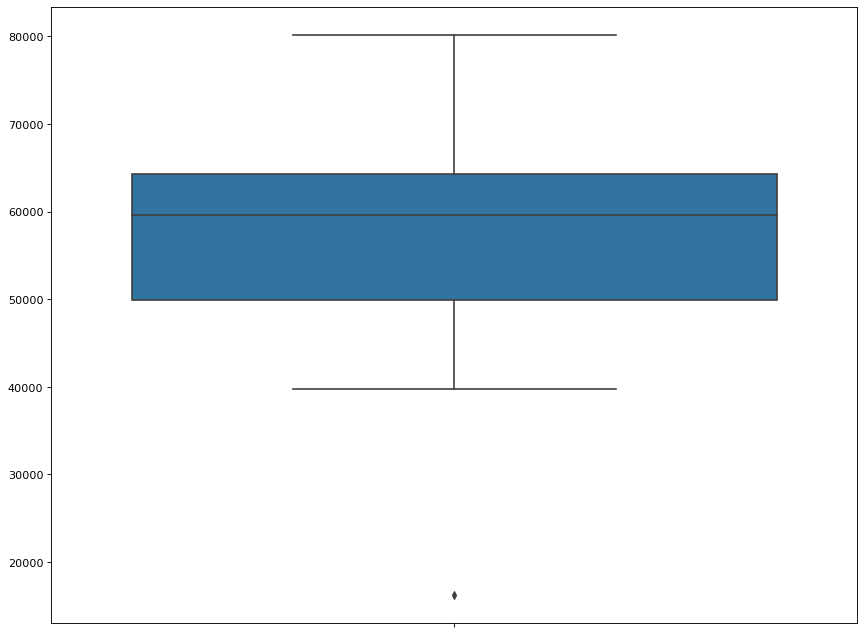

In [34]:
test1.Box_plot(test1.durations)

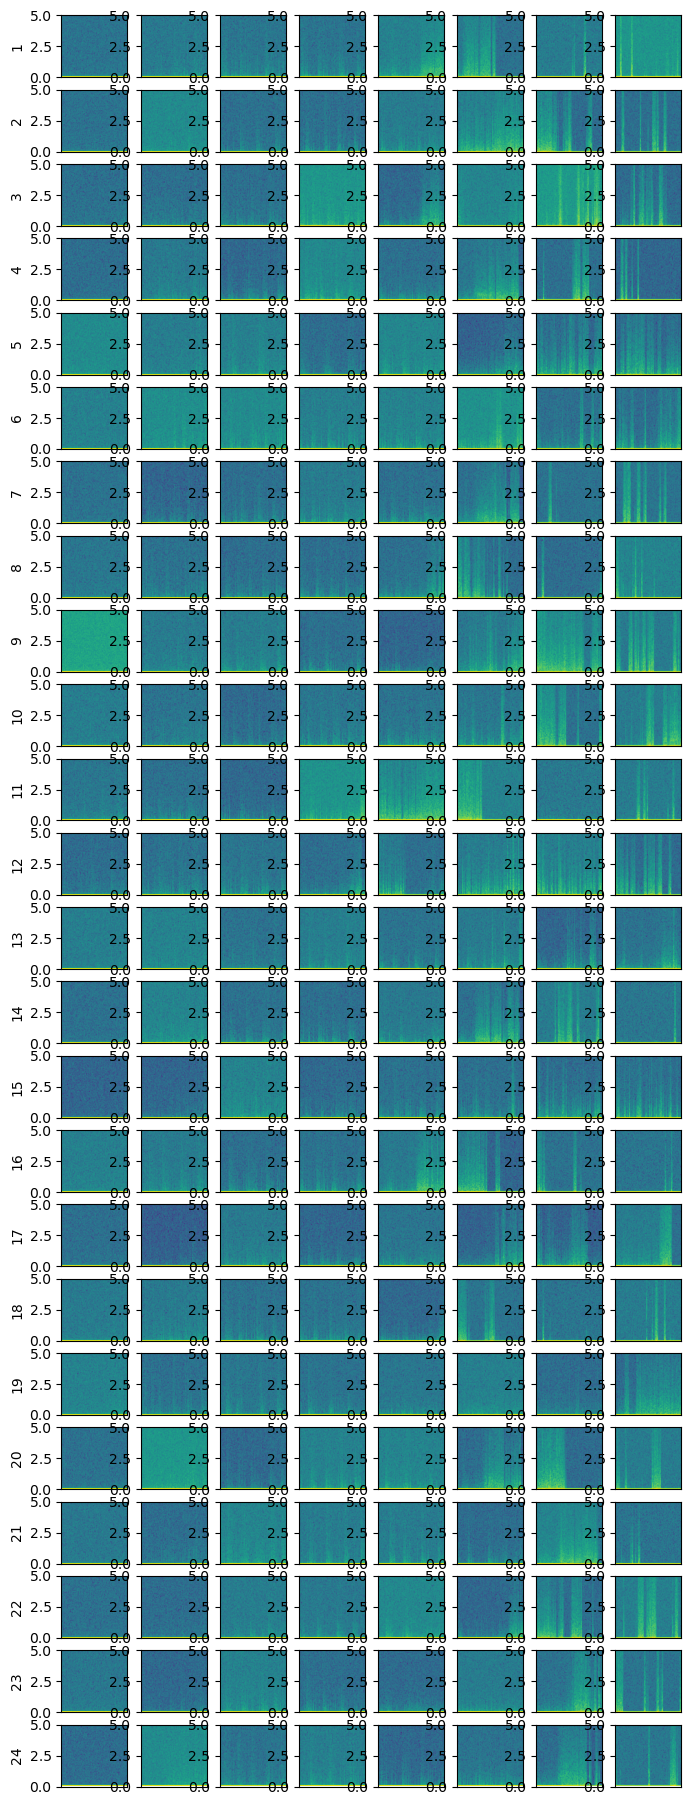

In [25]:
test1.specgram_plot(0)

In [27]:
#test1
def knn_norm(data, k=7, mode="max"):
        lenth = len(data)
        output_list = []
        for i in range(lenth - k):
            if mode == "max":
                output_list.append((np.max(data[i:i + k])))
            elif mode == "mean":
                output_list.append((np.mean(data[i:i + k])))
            elif mode == "min":
                output_list.append((np.min(data[i:i + k])))
        return np.hstack((np.ones(lenth-len(output_list))*output_list[0],np.array(output_list)))

f, ax = plt.subplots(24, 1, figsize=(20, 5*24))
'''for j in range(24):
    #ax[j].plot(knn_norm(data["Item"+str(j+1)+".avgBright"], 60, "max"))
    #ax[j].plot(knn_norm(data["Item"+str(j+1)+".avgBright"], 60, "min"))
    ax[j].plot(test1.datas[0]["Item"+str(j+1)+".avgBright"])
    #ax[j].vlines(test1.onset_points[0][j],0,np.max(data["Item"+str(j+1)+".avgBright"]), linestyles='-',color='blue', label='Predict Hatching Onset point')
    #ax[j].vlines(test1.hatching_points[0][j], 0,np.max(data["Item"+str(j+1)+".avgBright"]), linestyles='--', color='orange', label='Predict point')
    ax[j].grid()'''
for j in range(24):
    ax[j].plot(knn_norm(test1.filtered_signals[0][j],2000,"mean"))
    ax[j].vlines(test1.onset_points[0][j],0,np.max(test1.filtered_signals[0][j]), linestyles='-',color='blue', label='Predict Hatching Onset point')
    ax[j].vlines(test1.hatching_points[0][j], 0,np.max(test1.filtered_signals[0][j]), linestyles='--', color='orange', label='Predict point')
    ax[j].grid()
    ax[j].legend()
